In [1]:
import pandas as pd
import seaborn as sns
from scipy.integrate import cumtrapz
from scipy.signal import butter, filtfilt, periodogram, spectrogram, find_peaks
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11, 4)})
import numpy as np

In [2]:
df = pd.read_csv("../data/slow-walking.csv", header=None)
df.columns = ["time", "aX", "aY", "aZ", "gX", "gY", "gZ"]


In [3]:
# params
fs = 1000 / 100 # Hz, sampling frequency
total_time = df.time.max() - df.time.min()

In [4]:
def low_pass(data, fc, fs):
    w = fc / (fs / 2) # Normalize the frequency
    b, a = butter(5, w, 'low')
    return filtfilt(b, a, data)

def get_magnitude(data, cutoff_frequency=None, fs=None):
    magnitude = np.sqrt((data**2).sum(axis=1))
    if cutoff_frequency is None:
        return magnitude
    else:
        return low_pass(magnitude, cutoff_frequency, fs)

def peak_detection_steps(data, pos_kwargs=None, neg_kwargs=None):
    peaks, _ = find_peaks(data, **pos_kwargs)
    neg_peaks, _ = find_peaks(-data, **neg_kwargs)
    sns.lineplot(x=range(len(data)), y=data)
    sns.scatterplot(x=peaks, y=data[peaks])
    sns.scatterplot(x=neg_peaks, y=data[neg_peaks])
    plt.show()
    return len(peaks)

def fft_steps(data, dt, fs):
    f, Pxx = periodogram(data, fs=fs)
    sns.lineplot(f, Pxx)
    plt.show()
    return dt * f[np.argmax(Pxx)] / 1000

def autocorr(x):
    result = np.correlate(x, x, mode='same')
    return result[:]

def autocorr_steps(data):
    corr = autocorr(data)
    sns.lineplot(x=range(len(corr)), y=corr)
    peaks, _ = find_peaks(corr)
    sns.scatterplot(x=peaks, y=corr[peaks])
    plt.show()
    return len(peaks)

# Acceleration

<AxesSubplot:xlabel='time', ylabel='aZ'>

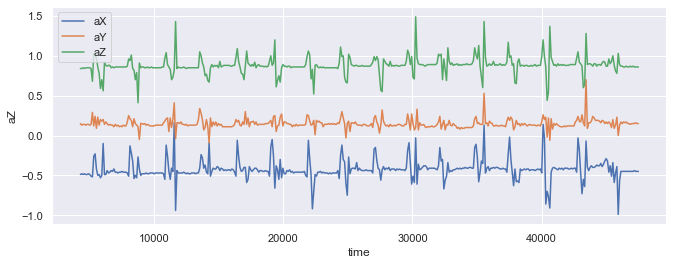

In [5]:
sns.lineplot(x=df.time, y=df.aX, label="aX")
sns.lineplot(x=df.time, y=df.aY, label="aY")
sns.lineplot(x=df.time, y=df.aZ, label="aZ")

<AxesSubplot:xlabel='time', ylabel='aZ'>

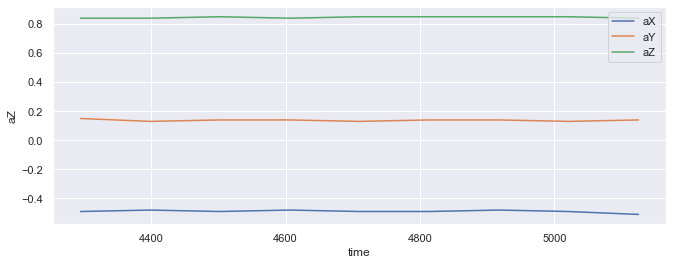

In [6]:
_df = df.iloc[:9]
sns.lineplot(x=_df.time, y=_df.aX, label="aX")
sns.lineplot(x=_df.time, y=_df.aY, label="aY")
sns.lineplot(x=_df.time, y=_df.aZ, label="aZ")

In [7]:
gravity_vector = _df.loc[:,["aX", "aY", "aZ"]].mean()
(gravity_vector, (gravity_vector**2).sum())

(aX   -0.488889
 aY    0.137778
 aZ    0.845556
 dtype: float64,
 0.9729592592592589)

In [8]:
df.loc[:,["aX", "aY", "aZ"]] = (df.loc[:,["aX", "aY", "aZ"]] - gravity_vector) * 9.8

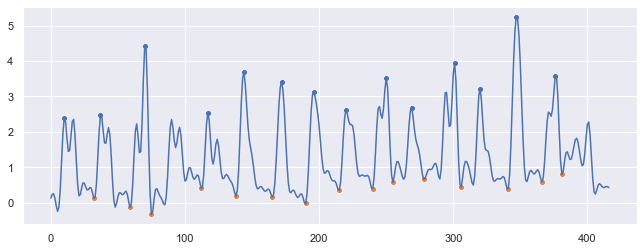

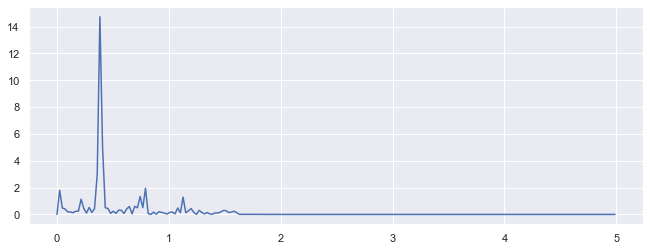

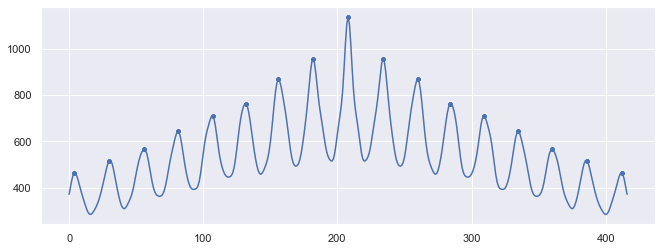

(14, 16.571318944844126, 17)

In [9]:
aMagnitude = get_magnitude(df.loc[:,["aX", "aY", "aZ"]], cutoff_frequency=1.5, fs=fs)
n_peak_steps = peak_detection_steps(
    aMagnitude, 
    pos_kwargs={
        "prominence": 2,
        "distance": 3
    }, 
    neg_kwargs={
        "prominence": 1
    }
)
n_fft_steps = fft_steps(aMagnitude, dt=total_time, fs=fs)
n_autocorr_steps = autocorr_steps(aMagnitude)
(n_peak_steps, n_fft_steps, n_autocorr_steps)

# Gyroscope

<AxesSubplot:xlabel='time', ylabel='gZ'>

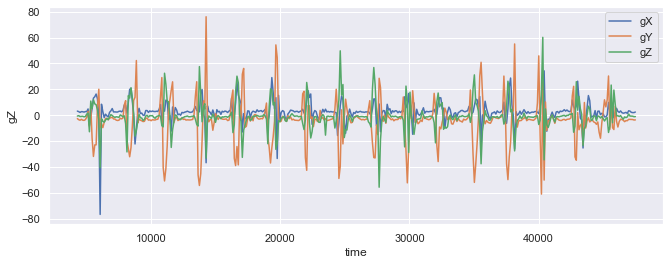

In [10]:
sns.lineplot(x=df.time, y=df.gX, label="gX")
sns.lineplot(x=df.time, y=df.gY, label="gY")
sns.lineplot(x=df.time, y=df.gZ, label="gZ")

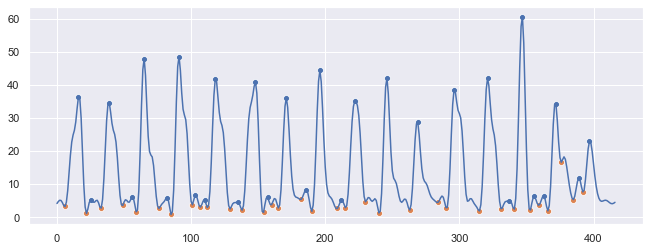

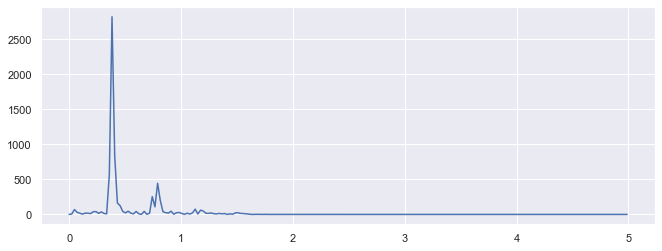

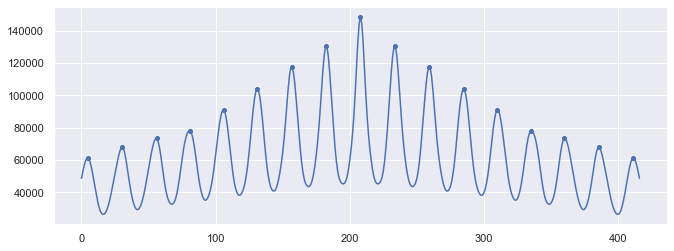

(29, 16.571318944844126, 17)

In [11]:
gMagnitude = get_magnitude(df.loc[:,["gX", "gY", "gZ"]], cutoff_frequency=1.5, fs=fs)
n_peak_steps = peak_detection_steps(
    gMagnitude, 
    pos_kwargs={
        "prominence": 2,
        "distance": 3
    }, 
    neg_kwargs={
        "prominence": 1
    }
)
n_fft_steps = fft_steps(gMagnitude, dt=total_time, fs=fs)
n_autocorr_steps = autocorr_steps(gMagnitude)
(n_peak_steps, n_fft_steps, n_autocorr_steps)